In [1]:
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)
tf.config.run_functions_eagerly(True)


Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


# FC GAN using MNIST

## 1-Importing Libraries

In [2]:
from tensorflow import keras

In [3]:
from keras.datasets import mnist
from keras.layers import Input,Dense,Reshape,Flatten
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential,Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np


In [4]:
img_cols = 28
img_rows = 28
channels = 1
img_shape = (img_rows,img_cols,channels)

## 2-building Generator Model

In [ ]:
def build_generator():
  noise_shape=(100,)
  model = Sequential()
  model.add(Dense(256,input_shape=noise_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dense(512))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dense(1024))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Dense(np.prod(img_shape),activation='tanh'))
  model.add(Reshape(img_shape))
  print('Generator Model Summery:\n',)
  model.summary()
  print('\n')
  noise = Input(shape=noise_shape)
  img = model(noise)
  return Model(noise,img)

## 2-building Discriminator Model

In [ ]:
def build_discriminator():
  
  model = Sequential()
  model.add(Flatten(input_shape=img_shape))
  model.add(Dense(512))
  model.add(LeakyReLU(alpha=0.2))
  
  model.add(Dense(256))
  model.add(LeakyReLU(alpha=0.2))
  
  model.add(Dense(1,activation='sigmoid'))
  
  print('Discriminator Model Summery:\n',)
  model.summary()
  print('\n')
  img = Input(shape=img_shape)
  validity = model(img)
  return Model(img,validity)

## 3-preparing metrics for models

In [ ]:
optimizer = Adam(0.0002,0.5)
generator = build_generator()
generator.compile(loss='binary_crossentropy',optimizer=optimizer)
discriminator=build_discriminator()
discriminator.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
discriminator.trainable=False
z = Input((100,))
img = generator(z)
valid = discriminator(img)
combined = Model(z,valid)
combined.compile(loss='binary_crossentropy',optimizer=optimizer)

Generator Model Summery:

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 256)               25856     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 256)               0         
                                                                 
 batch_normalization_3 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization_4 (Batc  (None, 512)              2048      
 hNormalization)            

In [ ]:
combined.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 100)]             0         
                                                                 
 model_3 (Functional)        (None, 28, 28, 1)         1493520   
                                                                 
 model_4 (Functional)        (None, 1)                 533505    
                                                                 
Total params: 2,027,025
Trainable params: 1,489,936
Non-trainable params: 537,089
_________________________________________________________________


## 4-train prepration

In [11]:
def save_imgs(epoch):
  r,c=5,5
  noise = np.random.normal(0,1,(r*c,100))
  gen_imgs = generator.predict(noise)
  gen_imgs = 0.5*gen_imgs+0.5
  fig,axs = plt.subplots(r,c)
  cnt=0
  for i in range(r):
    for j in range(c):
      axs[i,j].imshow(gen_imgs[cnt,:,:,0],cmap='gray')
      axs[i,j].axis('off')
      cnt+=1
  fig.savefig(f"mnist_{epoch}.png")
  #plt.close()

In [5]:
def train(epochs,batch_size=32,save_interval=50):
  (X_train,_),(_,_) = mnist.load_data()
  X_train = (X_train.astype(np.float32)-127.5)/127.5
  X_train = np.expand_dims(X_train,axis=3)
  half_batch = int(batch_size/2)
  
  for epoch in range(epochs):
    idx = np.random.randint(0,X_train.shape[0],half_batch)
    imgs = X_train[idx]
    noise = np.random.normal(0,1,(half_batch,100))
    gen_imgs = generator.predict(noise)
    d_loss_real = discriminator.train_on_batch(imgs,np.ones((half_batch,1)))
    d_loss_fake = discriminator.train_on_batch(gen_imgs,np.zeros((half_batch,1)))
    d_loss = 0.5*np.add(d_loss_real,d_loss_fake)
    noise = np.random.normal(0,1,(batch_size,100))
    valid_y = np.array(batch_size*[1])
    g_loss = combined.train_on_batch(noise,valid_y)

    print(f"{epoch} [D loss: {d_loss[0]},acc.:{round(100*d_loss[1],2)}] [G loss: {g_loss}] ")
    #print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
    if(epoch%save_interval==0):
      save_imgs(epoch)



## 5- Train model and show results

In [ ]:
train(11000,32,1000)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Streaming output truncated to the last 5000 lines.
5764 [D loss: 0.6037145256996155,acc.:68.75] [G loss: 0.9718296527862549] 
5765 [D loss: 0.7224927544593811,acc.:56.25] [G loss: 1.0416390895843506] 
5766 [D loss: 0.6257292926311493,acc.:59.38] [G loss: 1.0504648685455322] 
5767 [D loss: 0.5968049168586731,acc.:71.88] [G loss: 0.9596642255783081] 
5768 [D loss: 0.6326267123222351,acc.:65.62] [G loss: 0.8927170038223267] 
5769 [D loss: 0.6370681822299957,acc.:68.75] [G loss: 0.995933473110199] 
5770 [D loss: 0.6805467903614044,acc.:62.5] [G loss: 0.9956799745559692] 
5771 [D loss: 0.6059983372688293,acc.:65.62] [G loss: 0.9243190288543701] 
5772 [D loss: 0.634932279586792,acc.:62.5] [G loss: 0.8629143238067627] 
5773 [D loss: 0.6901623606681824,acc.:43.75] [G loss: 0.8952487707138062] 
5774 [D loss: 0.6082587540149689,acc.:68.75] [G loss: 0.9464480876922607] 
5775 [D loss: 0.6271353960037231,acc.:71.88] [G loss: 0.9813220500946045] 
5776 [D loss: 0.7031444311141968,acc.:50.0] [G loss: 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


0 [D loss: 0.6982031166553497,acc.:53.12] [G loss: 0.8657616376876831] 
1 [D loss: 0.6430976092815399,acc.:56.25] [G loss: 0.8554273843765259] 
2 [D loss: 0.7681925892829895,acc.:43.75] [G loss: 0.9431437253952026] 
3 [D loss: 0.7180889844894409,acc.:53.12] [G loss: 0.8467394709587097] 
4 [D loss: 0.6085702478885651,acc.:81.25] [G loss: 0.9169972538948059] 
5 [D loss: 0.8082850575447083,acc.:46.88] [G loss: 0.9407053589820862] 
6 [D loss: 0.6772388517856598,acc.:62.5] [G loss: 0.8500157594680786] 
7 [D loss: 0.6715753078460693,acc.:62.5] [G loss: 0.8441053628921509] 
8 [D loss: 0.684586375951767,acc.:65.62] [G loss: 0.909255862236023] 
9 [D loss: 0.6557841002941132,acc.:65.62] [G loss: 0.8804516792297363] 
10 [D loss: 0.643654078245163,acc.:59.38] [G loss: 0.8503405451774597] 
11 [D loss: 0.7868801951408386,acc.:40.62] [G loss: 0.8466562032699585] 
12 [D loss: 0.59308061003685,acc.:68.75] [G loss: 0.9068938493728638] 
13 [D loss: 0.6642000675201416,acc.:62.5] [G loss: 0.905082166194915

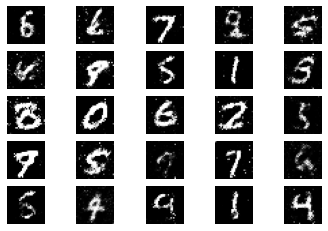

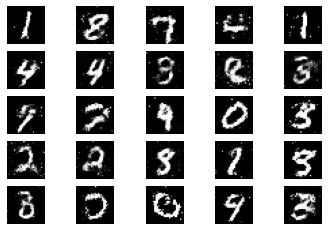

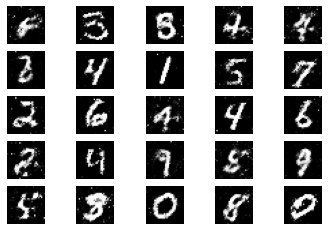

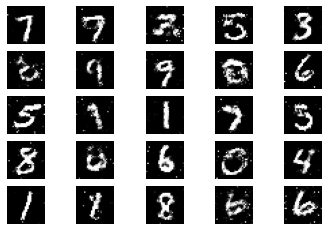

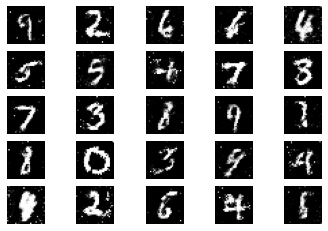

In [ ]:
train(5000,32,1000)

## 6- Save Model

In [ ]:
generator.save('/content/drive/MyDrive/macathon/FCGAN_Generator_16k.h5')

In [ ]:
discriminator.save('/content/drive/MyDrive/macathon/FCGAN_Discriminator_16k.h5')

In [ ]:
combined.save('/content/drive/MyDrive/macathon/FCGAN_FullGAN_16k.h5')

## 7-load and predict or train

In [6]:
from keras.models import load_model

In [9]:
generator = load_model('/content/drive/MyDrive/macathon/FCGAN_Generator_16k.h5')
discriminator = load_model('/content/drive/MyDrive/macathon/FCGAN_Discriminator_16k.h5')
combined = load_model('/content/drive/MyDrive/macathon/FCGAN_FullGAN_16k.h5')

### Predict:

In [ ]:
vector = np.random.randn(100).reshape(1,100)

In [ ]:
X = generator.predict(vector)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


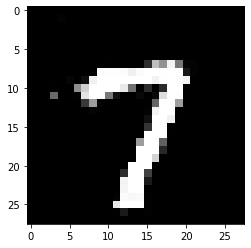

In [ ]:
plt.imshow(X[0,:,:,0],cmap='gray')

In [ ]:
(X_train,Y_train),(_,_) = mnist.load_data()

In [ ]:
np.where(Y_train==7)

(array([   15,    29,    38, ..., 59963, 59977, 59988]),)

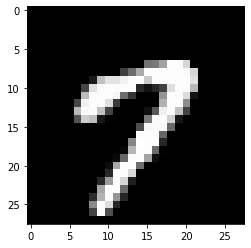

In [ ]:
plt.imshow(X_train[15,:,:],cmsap='gray')

### More Train:

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


0 [D loss: 0.7330302596092224,acc.:59.38] [G loss: 0.8130635619163513] 
1 [D loss: 0.72172611951828,acc.:59.38] [G loss: 0.8089052438735962] 
2 [D loss: 0.6684420704841614,acc.:56.25] [G loss: 0.7607752084732056] 
3 [D loss: 0.6607464253902435,acc.:50.0] [G loss: 0.7593770027160645] 
4 [D loss: 0.7124545276165009,acc.:62.5] [G loss: 0.8058563470840454] 
5 [D loss: 0.6020069718360901,acc.:62.5] [G loss: 0.7753938436508179] 
6 [D loss: 0.649707555770874,acc.:62.5] [G loss: 0.822767972946167] 
7 [D loss: 0.6317422091960907,acc.:71.88] [G loss: 0.7040565013885498] 
8 [D loss: 0.6244153380393982,acc.:68.75] [G loss: 0.7618311643600464] 
9 [D loss: 0.5951738357543945,acc.:75.0] [G loss: 0.7355877161026001] 
10 [D loss: 0.6756889224052429,acc.:65.62] [G loss: 0.7499325275421143] 
11 [D loss: 0.5694329142570496,acc.:71.88] [G loss: 0.6834802627563477] 
12 [D loss: 0.6789082884788513,acc.:46.88] [G loss: 0.708692193031311] 
13 [D loss: 0.6590412259101868,acc.:53.12] [G loss: 0.6844871044158936]

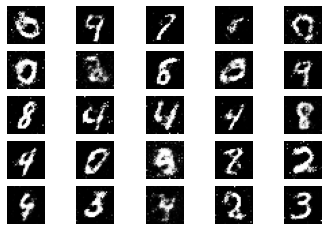

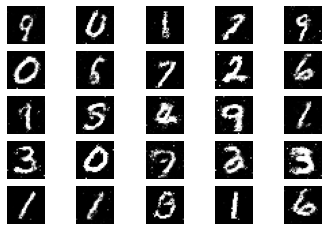

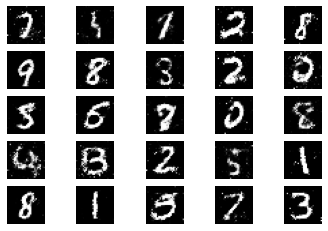

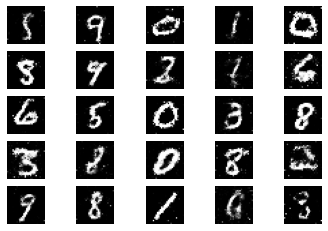

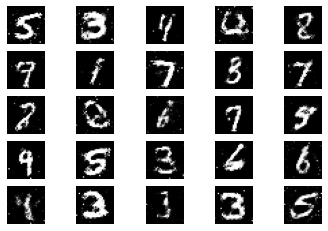

In [12]:
train(5000,32,1000)

In [13]:
generator.save('/content/drive/MyDrive/macathon/FCGAN_Generator_21k.h5')

In [14]:
discriminator.save('/content/drive/MyDrive/macathon/FCGAN_Discriminator_21k.h5')

In [15]:
combined.save('/content/drive/MyDrive/macathon/FCGAN_FullGAN_21k.h5')

In [93]:
vector = np.random.randn(100).reshape(1,100)

In [94]:
X = generator.predict(vector)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


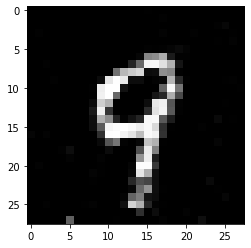

In [95]:
plt.imshow(X[0,:,:,0],cmap='gray')

In [69]:
(X_train,Y_train),(_,_) = mnist.load_data()

15

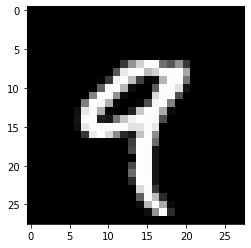

In [96]:
plt.imshow(X_train[np.where(Y_train==9)[0][0],:,:],cmap='gray')